In [ ]:
!pip install imutils

In [ ]:
#!pip install matplotlib-venn

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imutils
import pathlib
import time
import PIL as pil
import shutil

IMAGE_SIZE = (256, 256)
BASE_LR = 1e-3
EPOCH = 500
BATCH = 32
#EPOCH = 3

In [ ]:
import cv2
import imutils

def crop_img(img, image_size=(256, 256)):
    """
    Finds the extreme points on the image and crops the rectangular area out of them,
    then resizes the image to the specified image_size.
    """
    # Konversi gambar ke grayscale dan mengaburkan dengan Gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Thresholding untuk memisahkan objek dari latar belakang
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Temukan kontur pada gambar yang telah di-threshold
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)  # Ambil kontur terbesar

    # Temukan titik ekstrem (kiri, kanan, atas, bawah) dari kontur terbesar
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Pangkas gambar berdasarkan titik ekstrem
    ADD_PIXELS = 0  # Menambah piksel di sekitar area yang dipangkas jika diperlukan
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    # Ubah ukuran gambar menjadi image_size yang diinginkan
    new_img = cv2.resize(new_img, image_size)

    return new_img


In [ ]:
def crop_img(img, image_size=(256, 256)):
  """
  Finds the extreme points on the image and crops the rectangular out of them
  """
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosione +
  # dilations to remove any small region of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  # resize image
  new_img = cv2.resize(new_img, image_size)

  return new_img


In [ ]:
def image_preprocessing(source_dir, saved_root_dir, image_size=(256, 256), channels=3):
  if not os.path.exists(source_dir):
    raise Exception(f"Source directory, (source_dir) does not exist")
  else:
    if not os.path.isdir(saved_root_dir):
      raise Exception(f"Source directory, (source_dir) is not directory")

  if not os.path.exists(saved_root_dir):
    os.makedirs(saved_root_dir)

  source_dir_path = pathlib.Path(source_dir)

  #transform and save
  for p in source_dir_path.iterdir():
    dir_name = str(p).split('/')[-1]
    for fp in p.iterdir():
      filename = str(fp).split('/')[-1]
      img = tf.io.read_file(str(fp))
      img = tf.image.decode_jpeg(img, channels=channels)
      img = crop_img(img.numpy(), image_size)
      img = pil.Image.fromarray(img)
      saved_dist_dir = os.path.join(saved_root_dir, dir_name)
      if not os.path.exists(saved_dist_dir):
        os.makedirs(saved_dist_dir)
      img_dist_path = saved_dist_dir + '/' + f"{filename}"
      img.save(img_dist_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_preprocessing("/content/drive/MyDrive/6/Brain_Stroke_CT-SCAN_image/Train",

saved_root_dir = "/content/drive/MyDrive/6/Brain_Stroke_CT-SCAN_image/ujicoba/training", image_size=IMAGE_SIZE)

image_preprocessing("/content/drive/MyDrive/6/Brain_Stroke_CT-SCAN_image/Test",

saved_root_dir = "/content/drive/MyDrive/6/Brain_Stroke_CT-SCAN_image/ujicoba/testing", image_size=IMAGE_SIZE)

In [ ]:
root_dir_path = "/content/drive/MyDrive/6/Brain_Stroke_CT-SCAN_image/ujicoba"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(root_dir_path, "training"),
     label_mode="categorical",
     batch_size=16,
     image_size=IMAGE_SIZE,
     seed=42)

test_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(root_dir_path, "testing"),
     label_mode="categorical",
     image_size=IMAGE_SIZE,
     seed=42,
     validation_split=0.2,
     subset="both")

Found 1843 files belonging to 2 classes.
Found 437 files belonging to 2 classes.
Using 350 files for training.
Using 87 files for validation.


In [ ]:
print(train_ds.class_names)
print(test_ds.class_names)
cls_to_id = {c:i for i, c in enumerate(train_ds.class_names)}
print(cls_to_id)
id_to_cls = {i:c for i, c in enumerate(train_ds.class_names)}
print(id_to_cls)

['hemorrhagic', 'ischemic']
['hemorrhagic', 'ischemic']
{'hemorrhagic': 0, 'ischemic': 1}
{0: 'hemorrhagic', 1: 'ischemic'}


In [ ]:
with open("class_to_id.txt", "w") as f:
  for k, v in cls_to_id.items():
    f.write(f"{k}\t{v}\n")
with open("id_to_class.txt", "w") as f:
  for k, v in id_to_cls.items():
    f.write(f"{k}\t{v}\n")

In [ ]:
with open("class_to_id.txt", "r") as f:
  for line in f.readlines():
    cls, label = line.replace("\n","").split("\t")
print("\n")
with open("id_to_class.txt", "r") as f:
  for line in f.readlines():
    label, cls = line.replace("\n","").split("\t")
print(int(label), cls)



1 ischemic


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

def class_weight_from_one_hot(ds):
    class_labels = []

    # Ubah dataset menjadi unbatch jika dalam bentuk batch
    if ds.__class__.__name__ == "BatchDataset":
        ds = ds.unbatch()

    for _, onehot in ds:
        # Dapatkan indeks dari nilai maksimum untuk label one-hot dan konversi ke integer
        indices = tf.argmax(onehot, axis=-1).numpy()
        # Append all indices to the class_labels list
        class_labels.extend(indices)

    # Dapatkan daftar kelas unik dalam bentuk integer
    unique_classes = np.unique(class_labels)

    # Hitung bobot kelas menggunakan `compute_class_weight`
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=unique_classes,
        y=class_labels
    )

    # Mengonversi hasil bobot ke dalam format dictionary
    return {int(i): float(w) for i, w in zip(unique_classes, class_weights)}

# Hitung bobot kelas dari dataset latih
class_weights = class_weight_from_one_hot(train_ds)
print(class_weights)


{0: 1.218915343915344, 1: 0.8477460901563938}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def class_weight_from_one_hot(ds):
  class_labels = []
  if ds.__class__.__name__ == "BatchDataset":
    ds = ds.unbatch()

  for _, onehot in ds:
    #class_labels.append(tf.argmax(onehot, axis=None).numpy().item())
    # Get the index of the maximum value for each sample in the batch
    indices = tf.argmax(onehot, axis=-1).numpy()
    # Append all indices to the class_labels list
    class_labels.extend(indices)

  unique_classes = np.unique(class_labels)
  #unique_classes = unique_classes.astype(int)
  #unique_classes = np.array(unique_classes)
  class_weights = compute_class_weight(
      class_weight="balanced",
      classes=unique_classes,
      y=class_labels)
  return {i:w for i, w in enumerate(class_weights)}

class_weights = class_weight_from_one_hot(train_ds)
print(class_weights)

{0: 1.218915343915344, 1: 0.8477460901563938}


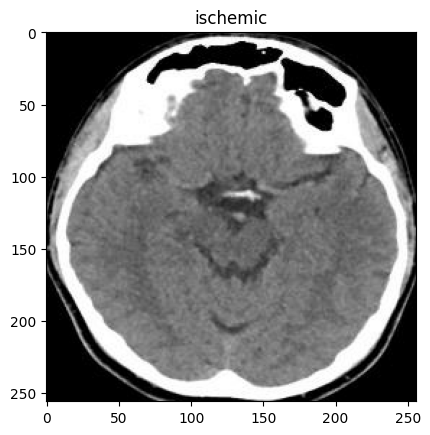

In [ ]:
for images, labels in train_ds.take(1):
  image, label = images[0], labels[0]
  plt.figure()
  plt.imshow(tf.cast(image, tf.uint8))
  plt.title(train_ds.class_names[tf.argmax(label).numpy()])
  plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import applications

def create_model():
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    input = tf.keras.layers.Input(shape=input_shape, name="input")

    # Augmentasi data
    x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(input)
    x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
    x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
    x = tf.keras.layers.RandomRotation(0.2)(x)

    # Model dasar EfficientNetB0
    base_model = applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model(x, training=False)

    # Tambahan lapisan pooling dan dropout
    x = tf.keras.layers.GlobalMaxPooling2D(name="max_pooling")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(2, activation="softmax", name="output")(x)

    # Membangun model
    model = tf.keras.Model(input, output)

    # Penjadwalan Learning Rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=1000,
        decay_rate=0.95)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model


In [ ]:
#!pip install tensorflow==2.13.0
#!pip install tensorflow --upgrade --user
#!pip install keras

from tensorflow import keras
# Explicitly import keras.applications
from tensorflow.keras import applications

def create_model():
  input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
  input = tf.keras.layers.Input(shape=input_shape, name="input")
  x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(input)
  x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
  x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
  x = tf.keras.layers.RandomRotation(0.2)(x)

  # Use applications module here
  base_model = applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
  #base_model = tf.keras.application.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet') ori

  #base_model.trainable = False
  #x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)

  # or None if you want to train from scratch
  x = base_model(x, training=False) # Fixed indentation
  x = tf.keras.layers.GlobalMaxPooling2D(name="max_pooling")(x) # Fixed indentation
  x = tf.keras.layers.Dropout(0.5)(x) # Fixed indentation
  output = tf.keras.layers.Dense(2, activation="softmax", name="output")(x) # Fixed indentation
    #x = base_model(x, training=False)
    #x = tf.keras.layers.GlobalMaxPooling2D(name="max_pooling")(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    #output = tf.keras.layers.Dense(2, activation="softmax", name="output")(x)

  model = tf.keras.Model(input, output)

  # Learning Rate Schedule
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-4,
      decay_steps=1000,
      decay_rate=0.95)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])

  return model

In [ ]:
model = create_model()
model.summary(show_trainable=True)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)                  │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_flip (RandomFlip)            │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_zoom (RandomZoom)            │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_translation                  │ (None, 256, 256, 3)          │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_rotation (RandomRotation)    │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetb0 (Functional)         │ (None, 8, 8, 1280)           │     4,049,571 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling (GlobalMaxPooling2D)    │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ output (Dense)                      │ (None, 2)                    │         2,562 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
pretrain_model_layer = 6
#freeze pretrain model
model.layers[pretrain_model_layer].trainable = False
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)                  │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_flip (RandomFlip)            │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_zoom (RandomZoom)            │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_translation                  │ (None, 256, 256, 3)          │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ random_rotation (RandomRotation)    │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetb0 (Functional)         │ (None, 8, 8, 1280)           │     4,049,571 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling (GlobalMaxPooling2D)    │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ output (Dense)                      │ (None, 2)                    │         2,562 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer=tf.keras.optimizers.Adam(BASE_LR),
              metrics=["categorical_accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=411, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=411)
]

history = model.fit(train_ds,
                    epochs=EPOCH,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    callbacks=cbs)

Epoch 1/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - categorical_accuracy: 0.5197 - loss: 3.6684 - val_categorical_accuracy: 0.4138 - val_loss: 0.7744 - learning_rate: 0.0010
Epoch 2/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_accuracy: 0.5213 - loss: 1.8075 - val_categorical_accuracy: 0.6322 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 3/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_accuracy: 0.5635 - loss: 1.2124 - val_categorical_accuracy: 0.5402 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 4/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_accuracy: 0.5012 - loss: 1.3117 - val_categorical_accuracy: 0.4713 - val_loss: 0.7584 - learning_rate: 0.0010
Epoch 5/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_accuracy: 0.5431 - loss: 0.9903 - val_categorical_accuracy: 0.3563 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 6/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_accuracy: 0.5295 - loss: 0.9826 - v

In [ ]:
# unfreeze top layers for training on pretrain model
fine_tune_at = 100
pretrain_model = model.layers[pretrain_model_layer -1]
pretrain_model.trainable = True
for layer in pretrain_model.layers[:fine_tune_at]:
    layer.trainable = True
for layer in pretrain_model.layers:
  print(layer.name, layer.output.shape, layer.trainable)


input_layer (None, 256, 256, 3) True
rescaling (None, 256, 256, 3) True
normalization (None, 256, 256, 3) True
rescaling_1 (None, 256, 256, 3) True
stem_conv_pad (None, 257, 257, 3) True
stem_conv (None, 128, 128, 32) True
stem_bn (None, 128, 128, 32) True
stem_activation (None, 128, 128, 32) True
block1a_dwconv (None, 128, 128, 32) True
block1a_bn (None, 128, 128, 32) True
block1a_activation (None, 128, 128, 32) True
block1a_se_squeeze (None, 32) True
block1a_se_reshape (None, 1, 1, 32) True
block1a_se_reduce (None, 1, 1, 8) True
block1a_se_expand (None, 1, 1, 32) True
block1a_se_excite (None, 128, 128, 32) True
block1a_project_conv (None, 128, 128, 16) True
block1a_project_bn (None, 128, 128, 16) True
block2a_expand_conv (None, 128, 128, 96) True
block2a_expand_bn (None, 128, 128, 96) True
block2a_expand_activation (None, 128, 128, 96) True
block2a_dwconv_pad (None, 129, 129, 96) True
block2a_dwconv (None, 64, 64, 96) True
block2a_bn (None, 64, 64, 96) True
block2a_activation (None, 

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer=tf.keras.optimizers.Adam(BASE_LR/10),
              metrics=["categorical_accuracy"])

In [ ]:
last_epoch = history.epoch[-1]

history_fine = model.fit(train_ds,
                    epochs=last_epoch+100,
                    initial_epoch=last_epoch,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    callbacks=cbs)

Epoch 500/599
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step - categorical_accuracy: 0.9781 - loss: 0.2470 - val_categorical_accuracy: 0.8506 - val_loss: 0.4770 - learning_rate: 1.0000e-04
Epoch 501/599
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - categorical_accuracy: 0.9897 - loss: 0.2251 - val_categorical_accuracy: 0.8391 - val_loss: 0.4968 - learning_rate: 1.0000e-04
Epoch 502/599
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - categorical_accuracy: 0.9831 - loss: 0.2305 - val_categorical_accuracy: 0.8391 - val_loss: 0.5189 - learning_rate: 1.0000e-04
Epoch 503/599
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_accuracy: 0.9909 - loss: 0.2175 - val_categorical_accuracy: 0.8506 - val_loss: 0.5425 - learning_rate: 1.0000e-04
Epoch 504/599
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - categorical_accuracy: 0.9943 - loss: 0.2141 - val_categorical_accuracy: 0.8391 - val_loss: 0.5315 - learning_rate: 1.0000e-04
Epoch 505/599
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - categorical_acc

In [ ]:
model.evaluate(test_ds)

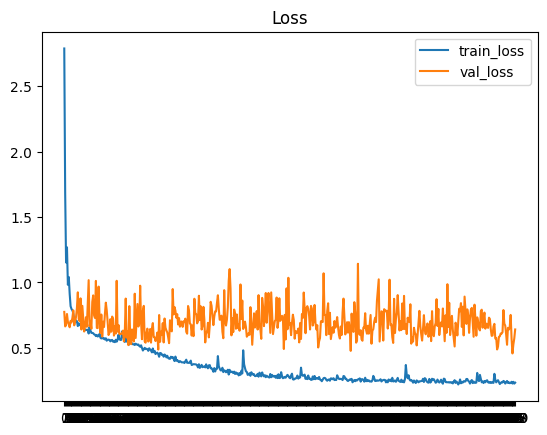

In [ ]:
plt.figure()
epochs = list(range(len(history.history["loss"])))
plt.plot(epochs, history.history["loss"], label="train_loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.xticks(ticks=epochs)
plt.title("Loss")
plt.legend()
plt.show()

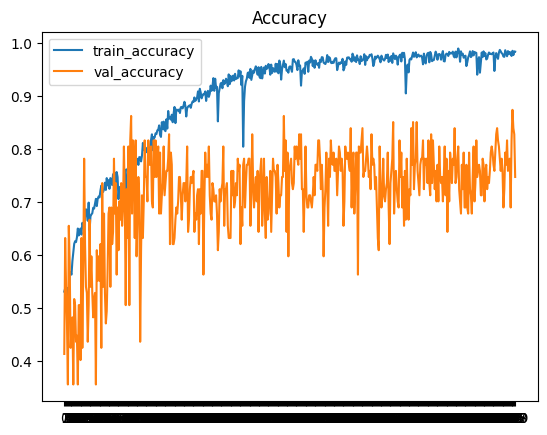

In [ ]:
plt.figure()
epochs = list(range(len(history.history["categorical_accuracy"])))
plt.plot(epochs, history.history["categorical_accuracy"], label="train_accuracy")
plt.plot(epochs, history.history["val_categorical_accuracy"], label="val_accuracy")
plt.xticks(ticks=epochs)
plt.title("Accuracy")
plt.legend()
plt.show()

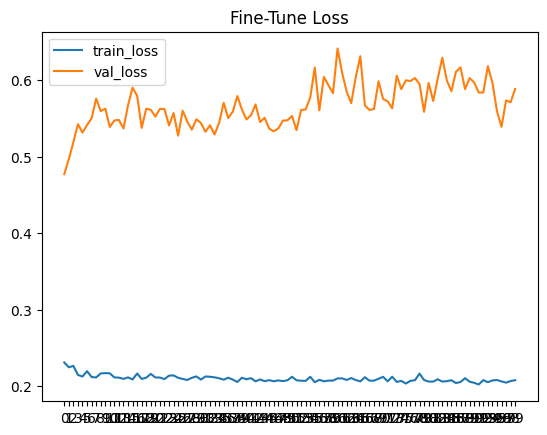

In [ ]:
plt.figure()
epochs = list(range(len(history_fine.history["loss"])))
plt.plot(epochs, history_fine.history["loss"], label="train_loss")
plt.plot(epochs, history_fine.history["val_loss"], label="val_loss")
plt.xticks(ticks=epochs)
plt.title("Fine-Tune Loss")
plt.legend()
plt.show()

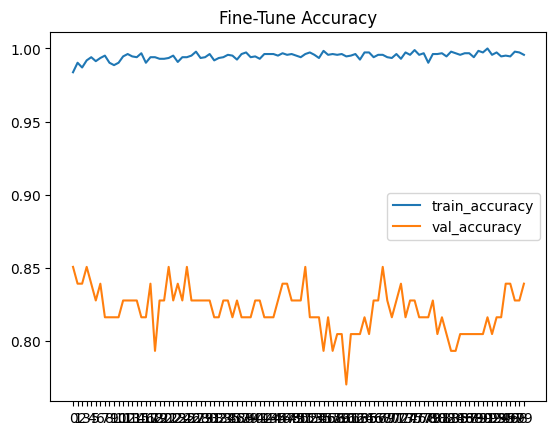

In [ ]:
plt.figure()
epochs = list(range(len(history_fine.history["categorical_accuracy"])))
plt.plot(epochs, history_fine.history["categorical_accuracy"], label="train_accuracy")
plt.plot(epochs, history_fine.history["val_categorical_accuracy"], label="val_accuracy")
plt.xticks(ticks=epochs)
plt.title("Fine-Tune Accuracy")
plt.legend()
plt.show()

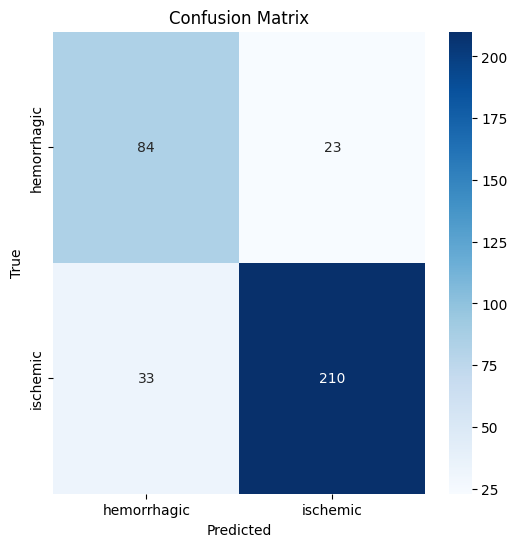

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan confusion matrix dalam bentuk heatmap
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Mendapatkan hasil prediksi dari model pada data uji (test_ds)
y_true = []
y_pred = []
for batch_imgs, batch_labels in test_ds:
  labels = [tf.argmax(one_hot_labels).numpy() for one_hot_labels in batch_labels]
  outputs = model.predict(batch_imgs, verbose=0)
  preds = [tf.argmax(output).numpy() for output in outputs]
  y_true.extend(labels)
  y_pred.extend(preds)

# Nama kelas yang digunakan dalam model
class_names = ['hemorrhagic', 'ischemic']

# Menampilkan confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
# inspect model performance
from sklearn.metrics import classification_report

def classi_report(test_ds):
  if test_ds.__class__.__name__ == "BatchDataset":
    test_ds = test_ds.unbatch().batch(32) # Mengonversi dataset pengujian ke bentuk yang sesuai

  y_true = []
  y_pred = []
  pred_times = []

  for batch_images, batch_labels in test_ds:
    labels = [tf.argmax(one_hot_labels).numpy() for one_hot_label in batch_labels]
    t1 = time.time()
    outputs = model.predict(batch_images, verbose=0)
    t2 = time.time()
    preds = [tf.argmax(output).numpy() for output in outputs]
    y_true.extend(labels)
    y_pred.extend(preds)
    pred_times.extend([t2 - t1] * len(labels))

  print(f"average prediction time: (np.mean(pred_times)) seconds")
  return classification_report(y_true, y_pred)

  # Calculate and print overall accuracy
  overall_accuracy = accuracy_score(y_true, y_pred)
  print(f"Overall Accuracy: {overall_accuracy}")

  print(classi_report(test_ds))

In [ ]:
import time
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

def classi_report(test_ds):
    # Jika dataset adalah BatchDataset, ubah ke format batch yang lebih kecil untuk pengujian
    if test_ds.__class__.__name__ == "BatchDataset":
        test_ds = test_ds.unbatch().batch(32)

    y_true = []
    y_pred = []
    pred_times = []

    for batch_images, batch_labels in test_ds:
        labels = [tf.argmax(one_hot_label).numpy() for one_hot_label in batch_labels]

        # Hitung waktu prediksi
        t1 = time.time()
        outputs = model.predict(batch_images, verbose=0)
        t2 = time.time()

        # Prediksi kelas
        preds = [tf.argmax(output).numpy() for output in outputs]
        y_true.extend(labels)
        y_pred.extend(preds)
        pred_times.extend([t2 - t1] * len(labels))

    # Rata-rata waktu prediksi
    print(f"Average prediction time: {np.mean(pred_times):.4f} seconds")

    # Laporan klasifikasi
    report = classification_report(y_true, y_pred)
    print(report)

    # Hitung dan cetak akurasi keseluruhan
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    return report

# Memanggil fungsi untuk dataset pengujian
print(classi_report(test_ds))


Average prediction time: 0.0848 seconds
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       107
           1       0.90      0.86      0.88       243

    accuracy                           0.84       350
   macro avg       0.81      0.82      0.82       350
weighted avg       0.85      0.84      0.84       350

Overall Accuracy: 0.8400
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       107
           1       0.90      0.86      0.88       243

    accuracy                           0.84       350
   macro avg       0.81      0.82      0.82       350
weighted avg       0.85      0.84      0.84       350



In [ ]:
from IPython.display import display
from ipywidgets import FileUpload, Output
import PIL.Image
import io
import numpy as np
import cv2 # import openCV

#Function to check if the image size is within a certain range
def is_valid_image_size(img):
  min_size = 100 # Adjust thin value based on your requirements
  max_size = 1000 # Adjust this value based on your requirements
  return min_size <= img.size[0] <= max_size and min_size <= img.size[1] <= max_size

  # Function to process uploaded image and make predictions
  def process_uploaded_image(file_contents):
    img = PIL.Image.open(io.BytesIO(file_contents))

    # check if the image is a valid size
    if not is_valid_image_size(img):
      return "Invalid image size. Please upload an Image within the specified size range."

    # convert the image to a color (3-channel) image if it is grayscale
    if img.mode != "RGB":
      img = img.convert('RGB')

    img = np.array(img)
    img = crop_img(img, IMAGE_SIZE)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    class_name = id_to_cls[predicted_class]
    return class_name

  # Create file upload widget and output widget
  upload = FileUpload(accept='image/*', multiple=False)
  output = Output()

  # Define a callback function to handle file uploads
  def on_upload_change(change):
    with output:
      output.clear_output()
      if upload.value:
        file_contents = upload.value[next(iter(upload.value))]['content']
        prediction_result = process_uploaded_image(file_contents)
        print(f"Prediction: {prediction_result}")

  # Attach the callback function to the file upload widget
  upload.observe(on_upload, names='_counter')

  # Display the widgets
  display(upload, output)

In [ ]:
from IPython.display import display
from ipywidgets import FileUpload, Output
import PIL.Image
import io
import numpy as np
import cv2 # import OpenCV

# Function to check if the image size is within a certain range
def is_valid_image_size(img):
    min_size = 100  # Adjust this value based on your requirements
    max_size = 1000  # Adjust this value based on your requirements
    return min_size <= img.size[0] <= max_size and min_size <= img.size[1] <= max_size

# Function to process uploaded image and make predictions
def process_uploaded_image(file_contents):
    img = PIL.Image.open(io.BytesIO(file_contents))

    # Check if the image is a valid size
    if not is_valid_image_size(img):
        return "Invalid image size. Please upload an image within the specified size range."

    # Convert the image to a color (3-channel) image if it is grayscale
    if img.mode != "RGB":
        img = img.convert('RGB')

    img = np.array(img)
    img = crop_img(img, IMAGE_SIZE)  # Assuming crop_img and IMAGE_SIZE are defined
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)  # Assuming model is defined and loaded
    predicted_class = np.argmax(prediction)
    class_name = id_to_cls[predicted_class]  # Assuming id_to_cls is a dictionary mapping
    return class_name

# Create file upload widget and output widget
upload = FileUpload(accept='image/*', multiple=False)
output = Output()

# Define a callback function to handle file uploads
def on_upload(change):
    with output:
        output.clear_output()
        if upload.value:
            file_contents = upload.value[next(iter(upload.value))]['content']
            prediction_result = process_uploaded_image(file_contents)
            print(f"Prediction: {prediction_result}")

# Attach the callback function to the file upload widget
upload.observe(on_upload, names='_counter')

# Display the widgets
display(upload, output)


FileUpload(value={}, accept='image/*', description='Upload')

Output()

In [ ]:
model.save('/content/drive/MyDrive/6/stroke_recog_modelll.keras')  # creates a HDF5 file 'my_model.h5'